# 1. Importing libraries

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

# 2. Importing cleaned dataset 

In [255]:
df = pd.read_csv("Cleaned_dataset_with_added_variables.csv",index_col=0)
df.shape

(205394, 31)

In [256]:
df.head(2)

,Longitude,Latitude,Status,Address Type,Severity Description,Collision Type,Number of People Involved,Number of Pedestrians Involved,Number of Bicycles Involved,Number of Vehicles Involved,...,Hit Parked Car,Year,Month,Date,Hour,Minute,Speed,Road Congestion,Road Length,Neighborhood
0,-122.292141,47.536087,Matched,Block,Property Damage Only Collision,Sideswipe,2,0,0,2,...,N,2018,12,12,15,49,48.0,2.36674,0.56104,Riverton
1,-122.335422,47.598752,Matched,Block,Property Damage Only Collision,Other,1,0,0,1,...,N,2018,12,16,2,44,85.0,-1.00000,0.36276,Seattle


# 3. Multivariate analysis and feature engineering for weather variables

In this section, we will do some more cleaning for the weather variables as there are categories in each variable that could be grouped together. We will also handle the 'other' and 'unknown' categories appropriately. 

### a. Weather

In [257]:
#Crunching summary statistics for the Weather variable
df_weather = pd.DataFrame()
df_weather['Weather'] = df['Weather'].value_counts()
df_weather['Percent'] = (df_weather['Weather']/df_weather['Weather'].sum())*100
print (df_weather)

                              Weather    Percent
Clear or Partly Cloudy         107245  52.214281
Unknown                         37706  18.357888
Raining                         31474  15.323719
Overcast                        26612  12.956562
Snowing                           882   0.429419
Other                             745   0.362718
Fog/Smog/Smoke                    548   0.266804
Sleet/Hail/Freezing Rain          109   0.053069
Blowing Sand or Dirt or Snow       48   0.023370
Severe Crosswind                   25   0.012172


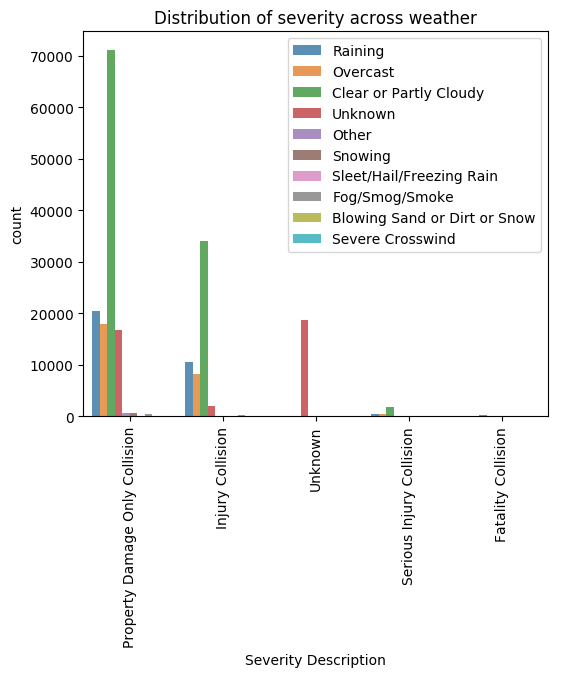

In [258]:
plt.figure(figsize=(6,5))
sns.countplot(x='Severity Description',data=df,hue='Weather',alpha=0.8)
plt.xticks(rotation=90)
plt.title('Distribution of severity across weather')
plt.style.use('default')
plt.legend(loc="upper right")
plt.show()

Note that the "Other" category essentially represents the same information as "Unknown". Hence, we can simply combine the "Unknown" and "Other" categories. 

In [259]:
df['Weather'] = df['Weather'].replace('Other','Unknown')
df['Weather'].value_counts()

Clear or Partly Cloudy          107245
Unknown                          38451
Raining                          31474
Overcast                         26612
Snowing                            882
Fog/Smog/Smoke                     548
Sleet/Hail/Freezing Rain           109
Blowing Sand or Dirt or Snow        48
Severe Crosswind                    25
Name: Weather, dtype: int64

We also notice from the frequency distribution above that categories such as *Sleet/Hail/Freezing Rain* and *Blowing Sand or Dirt or Snow* have very low frequencies as compared to other categories. Since most of the low frequency categories represent harsh/severe weather conditions, we can group them into a single category called "Severe Conditions". Later on, we can investige whether more severe collisions can be differentiated by the "Severe Conditions" category. 

Clear or Partly Cloudy    107245
Unknown                    38451
Raining                    31474
Overcast                   26612
Severe Conditions           1612
Name: Weather, dtype: int64


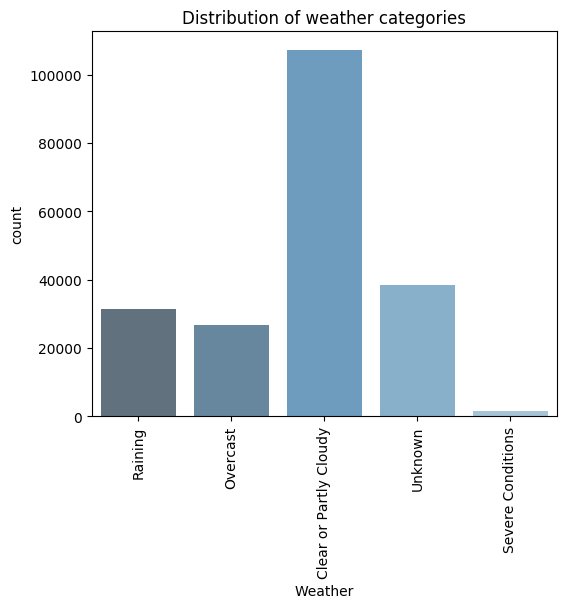

In [260]:
df['Weather'] = df['Weather'].replace(['Fog/Smog/Smoke','Sleet/Hail/Freezing Rain','Blowing Sand or Dirt or Snow','Severe Crosswind','Snowing'],'Severe Conditions')
print (df['Weather'].value_counts())
plt.figure(figsize=(6,5))
sns.countplot(x='Weather',data=df,alpha=0.8,palette='Blues_d')
plt.title('Distribution of weather categories')
plt.xticks(rotation=90)
plt.show()

In [261]:
#Crunching summary statistics for the Weather variable
df_weather = pd.DataFrame()
df_weather['Weather'] = df['Weather'].value_counts()
df_weather['Percent'] = (df_weather['Weather']/df_weather['Weather'].sum())*100
print (df_weather)

                        Weather    Percent
Clear or Partly Cloudy   107245  52.214281
Unknown                   38451  18.720605
Raining                   31474  15.323719
Overcast                  26612  12.956562
Severe Conditions          1612   0.784833


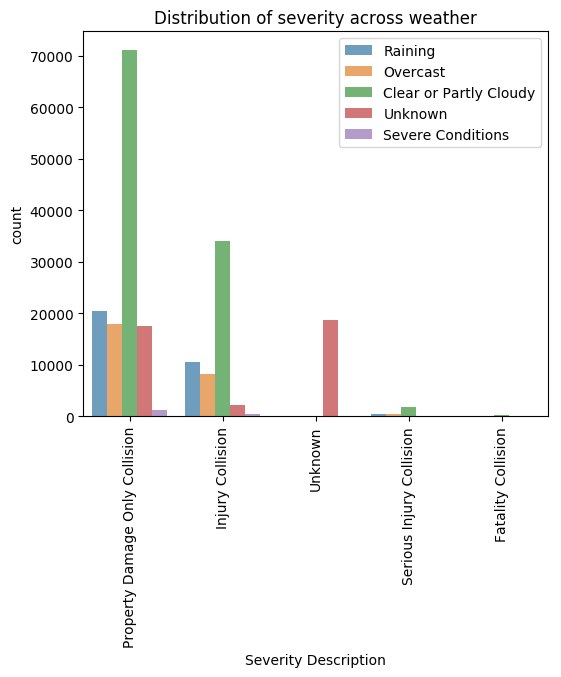

In [262]:
plt.figure(figsize=(6,5))
sns.countplot(x='Severity Description',data=df,hue='Weather',alpha=0.7)
plt.xticks(rotation=90)
plt.title('Distribution of severity across weather')
plt.legend(loc="upper right")
plt.show()

In [263]:
#Crunching summary statistics for the Weather variable
df_weather = pd.DataFrame()
df_weather['Weather'] = df['Weather'].value_counts()
df_weather['Percent'] = (df_weather['Weather']/df_weather['Weather'].sum())*100
print (df_weather)

                        Weather    Percent
Clear or Partly Cloudy   107245  52.214281
Unknown                   38451  18.720605
Raining                   31474  15.323719
Overcast                  26612  12.956562
Severe Conditions          1612   0.784833


From the plot and table above, we can see that property damaage is the highest occurring severity category followed by injury collision. Also, they contain a similar proportion of the weather categories which makes it hard to distinguish between the two categories. Serious injury and fatal collisions have a very small share of the collisions which is reflected in the graph. Also, there is nothing to suggest that a particular weather condition causes more severe collisions. 

Another striking thing to notice is that the unknown category constitutes 18.7% of the weather data.

### b. Road Conditions

In [264]:
#Crunching summary statistics for the Road Conditions variable
df_rc = pd.DataFrame()
df_rc['Road Condition'] = df['Road Condition'].value_counts()
df_rc['Percent'] = (df_rc['Road Condition']/df_rc['Road Condition'].sum())*100
print (df_rc)

                Road Condition    Percent
Dry                     120195  58.519236
Wet                      45172  21.992853
Unknown                  37534  18.274146
Ice                       1178   0.573532
Snow/Slush                 988   0.481027
Other                      112   0.054529
Standing Water             101   0.049174
Sand/Mud/Dirt               64   0.031160
Oil                         50   0.024343


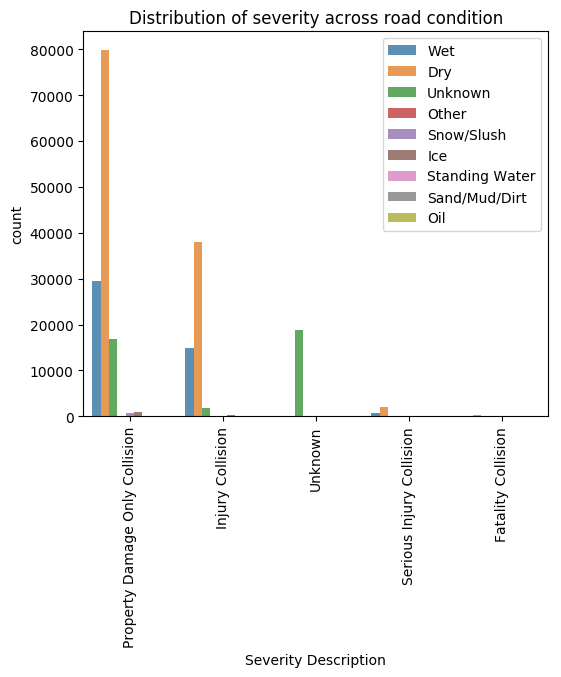

In [265]:
plt.figure(figsize=(6,5))
sns.countplot(x='Severity Description',hue='Road Condition',data=df,alpha=0.8)
plt.xticks(rotation=90)
plt.title('Distribution of severity across road condition')
plt.legend(loc="upper right")
plt.show()

Once again, we combine the "Other" and "Unknown" categories into one.

In [266]:
df['Road Condition'] = df['Road Condition'].replace('Other','Unknown')
df['Road Condition'].value_counts()

Dry               120195
Wet                45172
Unknown            37646
Ice                 1178
Snow/Slush           988
Standing Water       101
Sand/Mud/Dirt         64
Oil                   50
Name: Road Condition, dtype: int64

The other low frequency categories need to be handled slightly differently. We can combine "Snow/Slush" and "Ice" into a single category called "Snow/Ice". We merge the "Standing Water" and "Oil" categories into the "Wet" category whereas "Sand/Mud/Dirt" go into "Dry". 

In [267]:
df['Road Condition'] = df['Road Condition'].replace(['Snow/Slush','Ice'],'Snow/Ice')
df['Road Condition'] = df['Road Condition'].replace(['Standing Water','Oil'],'Wet')
df['Road Condition'] = df['Road Condition'].replace(['Sand/Mud/Dirt'],'Dry')
df['Road Condition'].value_counts()

Dry         120259
Wet          45323
Unknown      37646
Snow/Ice      2166
Name: Road Condition, dtype: int64

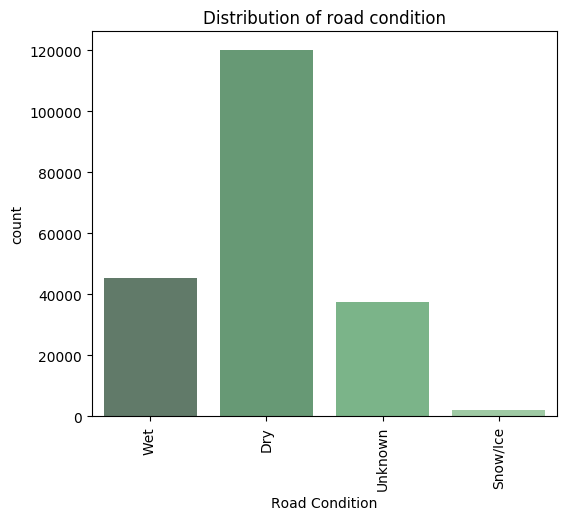

In [268]:
plt.figure(figsize=(6,5))
sns.countplot(x='Road Condition',data=df,alpha=0.8,palette='Greens_d')
plt.title('Distribution of road condition')
plt.xticks(rotation=90)
plt.show()

We are now left with categories that are easier to read and interpret. However, we still have the unknown category which we can deal with later. 

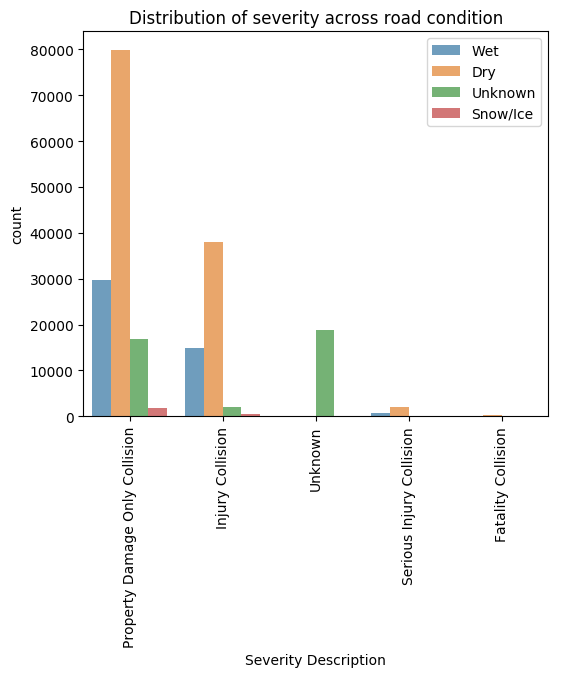

In [269]:
plt.figure(figsize=(6,5))
sns.countplot(x='Severity Description',hue='Road Condition',data=df,alpha=0.7)
plt.xticks(rotation=90)
plt.title('Distribution of severity across road condition')
plt.legend(loc="upper right")
plt.show()

Similar to the weather data, nothing for the road conditions suggests that a specific category affects severity. 

### c. Light Conditions

In [270]:
#Crunching summary statistics for the Light Conditions variable
df_lc = pd.DataFrame()
df_lc['Light Condition'] = df['Light Condition'].value_counts()
df_lc['Percent'] = (df_lc['Light Condition']/df_lc['Light Condition'].sum())*100
print (df_lc)

                          Light Condition    Percent
Daylight                           111552  54.311226
Dark - Street Lights On             46704  22.738736
Unknown                             36299  17.672863
Dusk                                 5711   2.780510
Dawn                                 2383   1.160209
Dark - No Street Lights              1415   0.688920
Dark - Street Lights Off             1151   0.560386
Other                                 179   0.087150


We first convert "Other" to "Unknown".

In [271]:
df['Light Condition'] = df['Light Condition'].replace('Other','Unknown')
df['Light Condition'].value_counts()

Daylight                    111552
Dark - Street Lights On      46704
Unknown                      36478
Dusk                          5711
Dawn                          2383
Dark - No Street Lights       1415
Dark - Street Lights Off      1151
Name: Light Condition, dtype: int64

Categories *Dark - No Street Lights* and *Dark - Street Lights Off* are combined into a single all-encompassing category which represents ligthing when there are no street lights in the dark. 

Also, categories *Dusk* and *Dawn* are combined into a single category since both refer to similar lighting conditions. The biggest difference between the two are the actual times of the day when they occur but our *Time* variable should account for that variability. 

In [272]:
df['Light Condition'] = df['Light Condition'].replace(['Dark - No Street Lights','Dark - Street Lights Off'],'Dark - No Street Lights')
df['Light Condition'] = df['Light Condition'].replace(['Dusk','Dawn'],'Dusk/Dawn')
df['Light Condition'].value_counts()

Daylight                   111552
Dark - Street Lights On     46704
Unknown                     36478
Dusk/Dawn                    8094
Dark - No Street Lights      2566
Name: Light Condition, dtype: int64

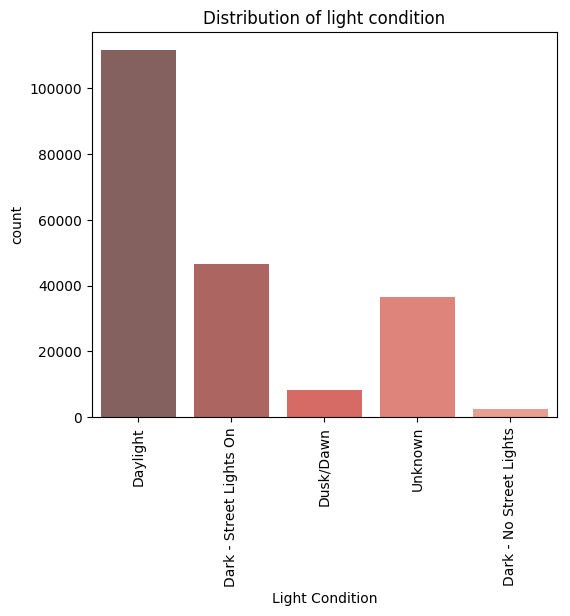

In [273]:
plt.figure(figsize=(6,5))
sns.countplot(x='Light Condition',data=df,alpha=0.8,palette='Reds_d')
plt.title('Distribution of light condition')
plt.xticks(rotation=90)
plt.show()

We now have some more meaningful categories with daylight being the most prevalent, which is expected since the traffic flow is highest during day time which provides the opportunity for greater number of collisions. There are greater number of collisions during the dark when street lights are on than when lights are off. This could be due to the fact that important roads tend to have street lights on them which also sees a higher rate of traffic. It would make sense that there would be fewer cars on the road during dawn. Also, it makes sense that there would be more collisions during dark than at dusk or dawn. 

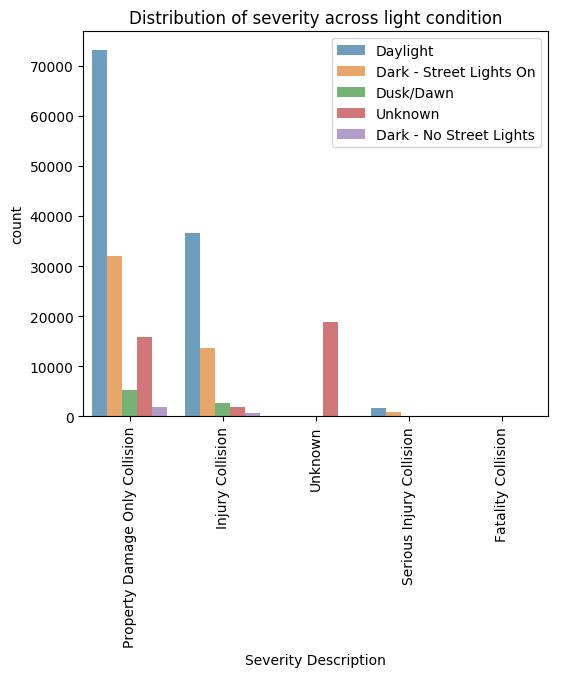

In [274]:
plt.figure(figsize=(6,5))
sns.countplot(x='Severity Description',hue='Light Condition',data=df,alpha=0.7)
plt.xticks(rotation=90)
plt.title('Distribution of severity across light condition')
plt.legend(loc="upper right")
plt.show()

Once again, the light condition data does not provide much information to differentiate between the severity categories. 

In [275]:
df_neighborhood = df[['Neighborhood','Severity Description','Latitude']].groupby(['Neighborhood','Severity Description']).count().unstack()
#df_neighborhood = df_neighborhood.apply(np.mean)
df_neighborhood

Latitude                   \
Severity Description Fatality Collision Injury Collision   
Neighborhood                                               
Boulevard Park                      5.0            459.0   
Bryn Mawr-Skyway                   19.0           1472.0   
Inglewood-Finn Hill                 2.0            459.0   
Kirkland                            NaN              NaN   
Lake Forest Park                   10.0           2024.0   
Medina                              1.0             43.0   
Mercer Island                       5.0            951.0   
Riverton                           11.0           1333.0   
Seattle                           177.0          33509.0   
Shoreline                          44.0           8348.0   
Tukwila                             NaN             12.0   
White Center                       43.0           6459.0   
Yarrow Point                        2.0            170.0   

                                                                              \
Severity Description Property Damage Only Collision Serious Injury Collision   
Neighborhood                                                                   
Boulevard Park                               1173.0                     23.0   
Bryn Mawr-Skyway                             3311.0                     81.0   
Inglewood-Finn Hill                           971.0                     26.0   
Kirkland                                        NaN                      NaN   
Lake Forest Park                             3482.0                     90.0   
Medina                                        349.0                      4.0   
Mercer Island                                2316.0                     42.0   
Riverton                                     2968.0                     65.0   
Seattle                                     82262.0                   1747.0   
Shoreline                                   16260.0                    448.0   
Tukwila                                        37.0                      NaN   
White Center                                14551.0                    380.0   
Yarrow Point                                  478.0                     10.0   

                               
Severity Description  Unknown  
Neighborhood                   
Boulevard Park          102.0  
Bryn Mawr-Skyway        325.0  
Inglewood-Finn Hill     188.0  
Kirkland                  1.0  
Lake Forest Park        555.0  
Medina                   68.0  
Mercer Island           294.0  
Riverton                324.0  
Seattle               12353.0  
Shoreline              2658.0  
Tukwila                   5.0  
White Center           1777.0  
Yarrow Point            112.0

# 4. Converting severity categories into binary classes

Below we convert the data into two main severity categories - *severe* and *not severe*. We do this for the following reasons:
- To simplify the problem into a binary classification one so that it's easier to work with
- To increase the number of more severe cases by combining the serious injury and fatality categories. This is done to overcome the class imbalance problem to an extent
- The results would be easier to interpret and more actionable 

In [276]:
#Making a copy of the original dataframe 
df_binary = df
df_binary['Severity Description'] = df_binary['Severity Description'].replace(['Fatality Collision','Serious Injury Collision'],'Severe')
df_binary['Severity Description'] = df_binary['Severity Description'].replace(['Property Damage Only Collision','Injury Collision'],'Not Severe')

In [277]:
severity = pd.DataFrame()
severity['Count'] = df_binary['Severity Description'].value_counts()
severity['Severity Rate'] = severity['Count'].apply(lambda x: x/sum(severity['Count'])*100)
severity

,Count,Severity Rate
Not Severe,183397,89.290340
Unknown,18762,9.134639
Severe,3235,1.575022


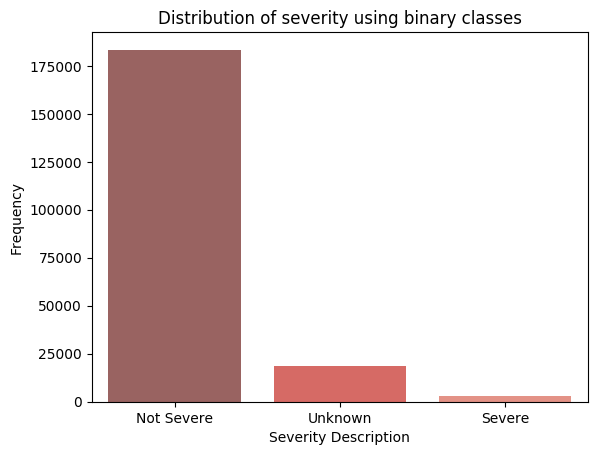

In [278]:
sns.countplot(x='Severity Description',data=df_binary,alpha=0.8,palette='Reds_d')
plt.title('Distribution of severity using binary classes')
plt.ylabel('Frequency')
plt.show()

Following the conversion into binary classes, we notice that the number of severe instances comprise only 1.57% of the data while the non-severe cases comprise a massive 89.29%. We still have the *Unknown* category in the data which we will handle later. 

From the correlation matrix above, we notice that there are a few variables that have some correlation with one another.

*Note that categorical variables won't show up as correlation can only be determined for continnous variables. Hence, the severity variable will also not be displayed, which prevents us from correlating these variables directly with it. However, we can perform multivariate analysis to find a relationship.*

# 4. Multivariate analysis - exploring the 'unknown' severity category

### a. Hit Parked Car vs Severity Description 

In [279]:
df_binary['Hit Parked Car'].value_counts()

N    195431
Y      9963
Name: Hit Parked Car, dtype: int64

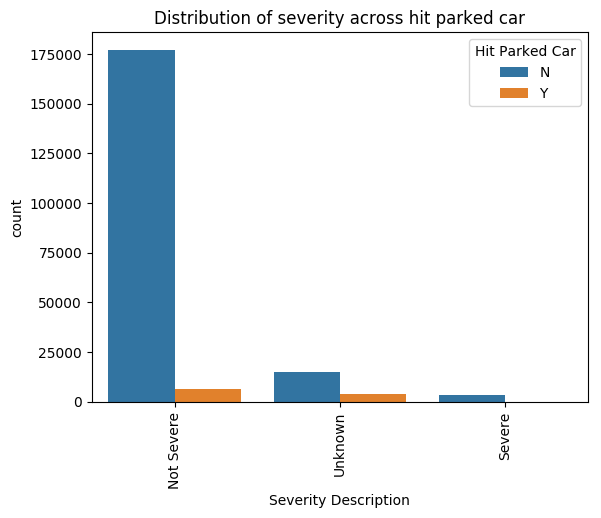

In [280]:
sns.countplot(hue='Hit Parked Car',x='Severity Description',data=df_binary)
plt.xticks(rotation=90)
plt.title('Distribution of severity across hit parked car')
plt.show()

In [281]:
df_binary[['Hit Parked Car','Severity Description','Latitude']].groupby(['Severity Description','Hit Parked Car']).count()

Latitude
Severity Description Hit Parked Car          
Not Severe           N                 177213
                     Y                   6184
Severe               N                   3216
                     Y                     19
Unknown              N                  15002
                     Y                   3760

From the information above, we observe a similar trend across all severity categories including unknown. 

### b. Neighborhood vs Severity Description

In [282]:
#Looking at the distribution of neighborhoods
df_binary['Neighborhood'].value_counts()

Seattle                130048
Shoreline               27758
White Center            23210
Lake Forest Park         6161
Bryn Mawr-Skyway         5208
Riverton                 4701
Mercer Island            3608
Boulevard Park           1762
Inglewood-Finn Hill      1646
Yarrow Point              772
Medina                    465
Tukwila                    54
Kirkland                    1
Name: Neighborhood, dtype: int64

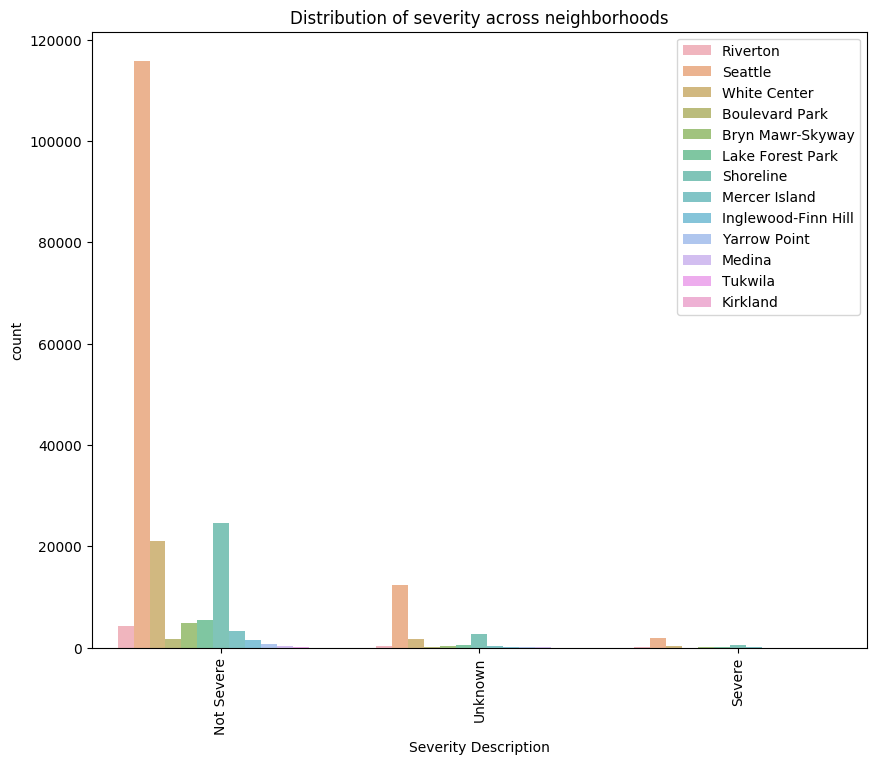

In [283]:
plt.figure(figsize=(10,8))
sns.countplot(x='Severity Description',hue='Neighborhood',data=df_binary,alpha=0.7)
plt.xticks(rotation=90)
plt.title('Distribution of severity across neighborhoods')
plt.legend(loc="upper right")
plt.show()

From analyzing the neighborhood variable, it is clear that the most prevalent areas are *Seattle*, *Shoreline* and *White Center*. This is true across both the non-severe case and the unknown case. In fact, the distribution for the unknown case is very similar to that of the non-severe case. 

### c. Number of People Involved vs Severity Description

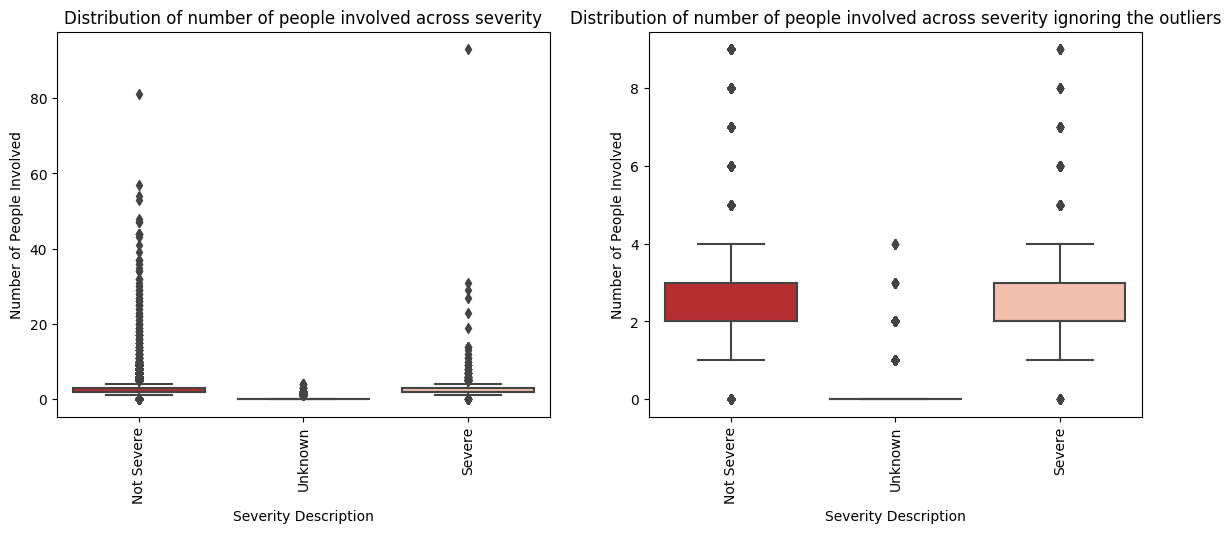

In [284]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.boxplot(x='Severity Description',y='Number of People Involved',data=df_binary,palette='Reds_r')
plt.title('Distribution of number of people involved across severity')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.boxplot(x='Severity Description',y='Number of People Involved',data=df_binary[df_binary['Number of People Involved']<10],palette='Reds_r')
plt.xticks(rotation=90)
plt.title('Distribution of number of people involved across severity ignoring the outliers')
plt.show()

In [285]:
#Finding the total number of people involved for each severity
NumPeopleSevPivot = df_binary[['Severity Description','Number of People Involved']].pivot_table(index='Severity Description',aggfunc=['count','sum','mean','median'])
NumPeopleSevPivot.columns = ['Count','Sum','Mean','Median']
print (NumPeopleSevPivot)

                       Count     Sum      Mean  Median
Severity Description                                  
Not Severe            183397  449595  2.451485       2
Severe                  3235    8553  2.643895       2
Unknown                18762    3602  0.191984       0


Interestingly, the medians for all the severity levels are same when it comes to the number of people involved. This is reflected in the boxplot as well where all the boxes are essentially at the same level. 

The mean value is more useful in visualizing the difference across severity levels.  

Below, to emphasize the mean value, we square the number of people values. As expected, there is now a greater difference in the mean values following the squaring which emphasizes the difference between the severity categories better. 

In [286]:
#Creating an additional variable which is the square of the number of people involved in order to 
#emphasise the different collision levels
df_binary['Num People Square'] = df_binary['Number of People Involved'].apply(np.square)
NumPeopleSevPivot = df_binary[['Severity Description','Num People Square']].pivot_table(index='Severity Description',aggfunc=['count','sum','mean','median'])
NumPeopleSevPivot.columns = ['Count','Sum','Mean','Median']
NumPeopleSevPivot = NumPeopleSevPivot.sort_values('Mean',ascending=False)
print (NumPeopleSevPivot)

                       Count      Sum       Mean  Median
Severity Description                                    
Severe                  3235    39763  12.291499       4
Not Severe            183397  1439541   7.849316       4
Unknown                18762     7046   0.375546       0


In terms of the unknown category, it should not affect the result since the values are much lower than those of the other categories. 

### d. Number of Vehicles Involved vs Severity Description

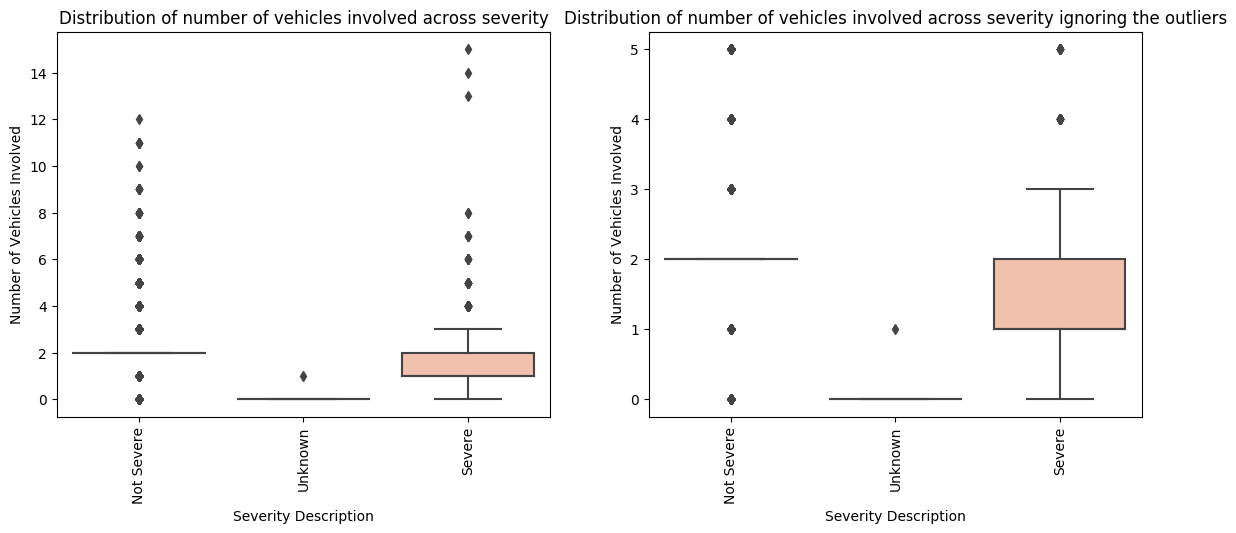

In [287]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.boxplot(x='Severity Description',y='Number of Vehicles Involved',data=df_binary,palette='Reds_r')
plt.xticks(rotation=90)
plt.title('Distribution of number of vehicles involved across severity')
plt.subplot(1,2,2)
sns.boxplot(x='Severity Description',y='Number of Vehicles Involved',data=df_binary[df_binary['Number of Vehicles Involved']<6],palette='Reds_r')
plt.xticks(rotation=90)
plt.title('Distribution of number of vehicles involved across severity ignoring the outliers')
plt.show()

In [288]:
#Finding the total number of people involved for each severity
NumVehSevPivot = df_binary[['Severity Description','Number of Vehicles Involved']].pivot_table(index='Severity Description',aggfunc=['count','sum','mean','median'])
NumVehSevPivot.columns = ['Count','Sum','Mean','Median']
NumVehSevPivot = NumVehSevPivot.sort_values('Mean',ascending=False)
print (NumVehSevPivot)

                       Count     Sum      Mean  Median
Severity Description                                  
Not Severe            183397  352493  1.922022       2
Severe                  3235    5043  1.558887       1
Unknown                18762       1  0.000053       0


### Status vs Severity Description

In [289]:
df_binary['Status'].value_counts()

Matched      181742
Unmatched     23652
Name: Status, dtype: int64

In [290]:
df_binary[['Status','Severity Description','Neighborhood']].groupby(['Status','Severity Description']).count().unstack()

Neighborhood               
Severity Description   Not Severe Severe Unknown
Status                                          
Matched                    178524   3163      55
Unmatched                    4873     72   18707

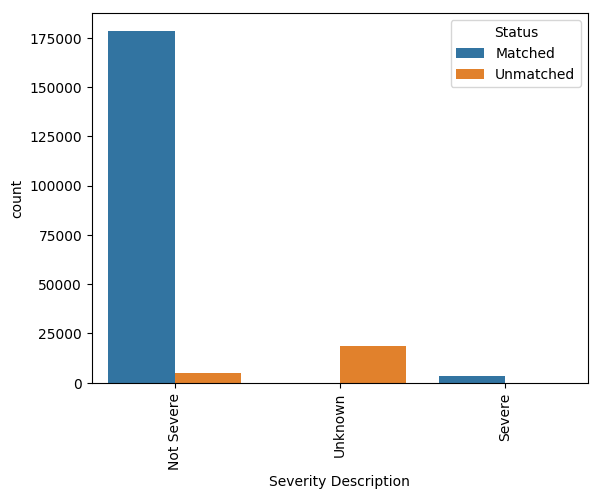

In [291]:
sns.countplot(hue='Status',x='Severity Description',data=df_binary)
plt.xticks(rotation=90)
plt.show()

### Address Type vs Severity Description

In [292]:
df_binary['Address Type'].value_counts()

Block           136971
Intersection     68423
Name: Address Type, dtype: int64

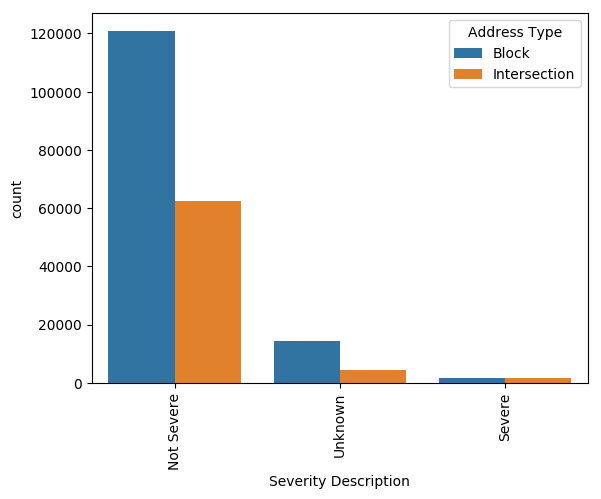

In [293]:
sns.countplot(hue='Address Type',x='Severity Description',data=df_binary)
plt.xticks(rotation=90)
plt.show()

In [294]:
df_addtype = df[['Address Type','Severity Description','Latitude']].groupby(['Address Type','Severity Description']).count().unstack()
df_addtype

Latitude               
Severity Description Not Severe Severe Unknown
Address Type                                  
Block                    120929   1597   14445
Intersection              62468   1638    4317

### Collision Type vs Severity Description

In [295]:
df_binary['Collision Type'].value_counts()

Parked Car    45384
Angles        33595
Rear Ended    32161
Unknown       23726
Other         22115
Sideswipe     17381
Left Turn     13427
Pedestrian     7139
Cycles         5570
Right Turn     2853
Head On        2043
Name: Collision Type, dtype: int64

In [296]:
df_coltype = df[['Collision Type','Severity Description','Latitude']].groupby(['Collision Type','Severity Description']).count().unstack()
df_coltype

Latitude                
Severity Description Not Severe Severe  Unknown
Collision Type                                 
Angles                  33146.0  448.0      1.0
Cycles                   5148.0  422.0      NaN
Head On                  1930.0  113.0      NaN
Left Turn               13152.0  275.0      NaN
Other                   21574.0  541.0      NaN
Parked Car              45255.0  129.0      NaN
Pedestrian               6225.0  914.0      NaN
Rear Ended              31937.0  224.0      NaN
Right Turn               2834.0   19.0      NaN
Sideswipe               17303.0   78.0      NaN
Unknown                  4893.0   72.0  18761.0

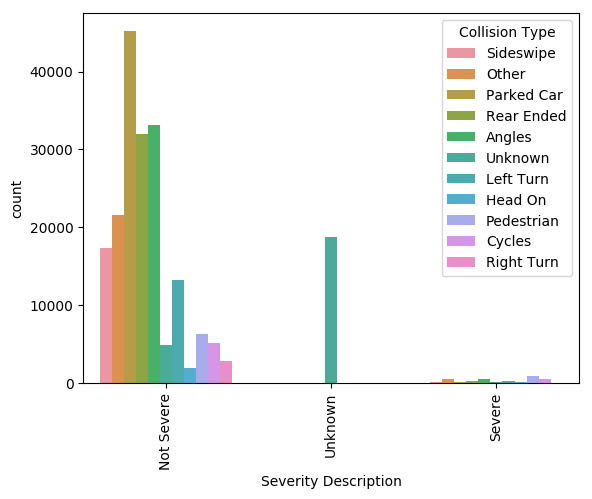

In [297]:
sns.countplot(hue='Collision Type',x='Severity Description',data=df_binary)
plt.xticks(rotation=90)
plt.show()

### Junction Type vs Severity Description

In [298]:
df['Junction Type'].value_counts()

Mid-Block (not related to intersection)              94254
At Intersection (intersection related)               65741
Mid-Block (but intersection related)                 23679
Driveway Junction                                    11073
Unknown                                               8047
At Intersection (but not related to intersection)     2436
Ramp Junction                                          164
Name: Junction Type, dtype: int64

In [299]:
df_junctype = df[['Junction Type','Severity Description','Latitude']].groupby(['Junction Type','Severity Description']).count().unstack()
df_junctype

Latitude               
Severity Description                              Not Severe Severe Unknown
Junction Type                                                              
At Intersection (but not related to intersection)       2047     27     362
At Intersection (intersection related)                 60235   1605    3901
Driveway Junction                                      10315    142     616
Mid-Block (but intersection related)                   22185    198    1296
Mid-Block (not related to intersection)                84195   1243    8816
Ramp Junction                                            143      3      18
Unknown                                                 4277     17    3753

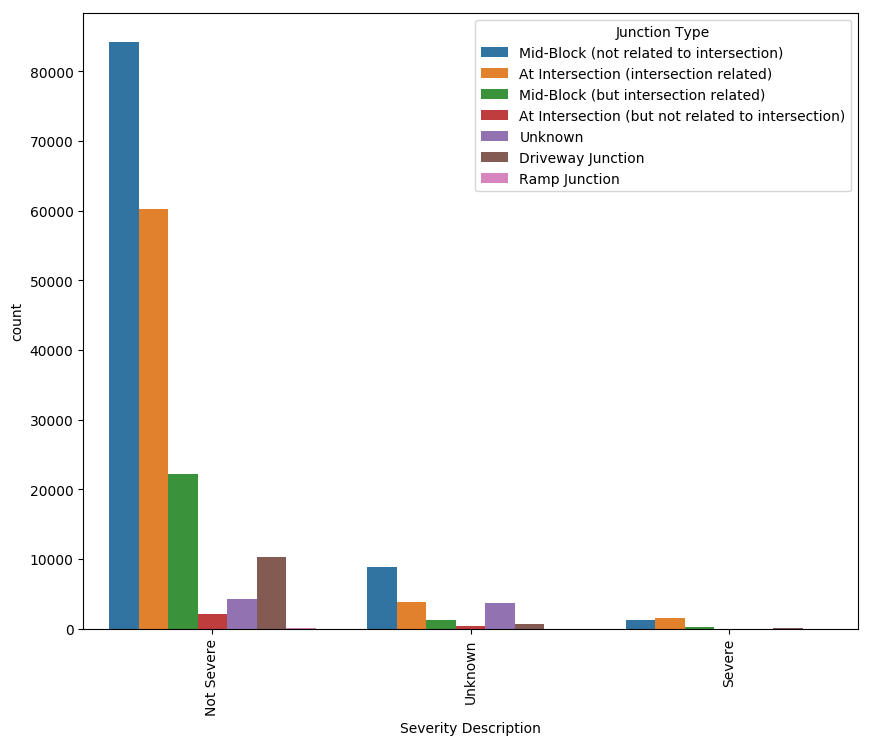

In [300]:
plt.figure(figsize=(10,8))
sns.countplot(hue='Junction Type',x='Severity Description',data=df_binary)
plt.xticks(rotation=90)
plt.show()

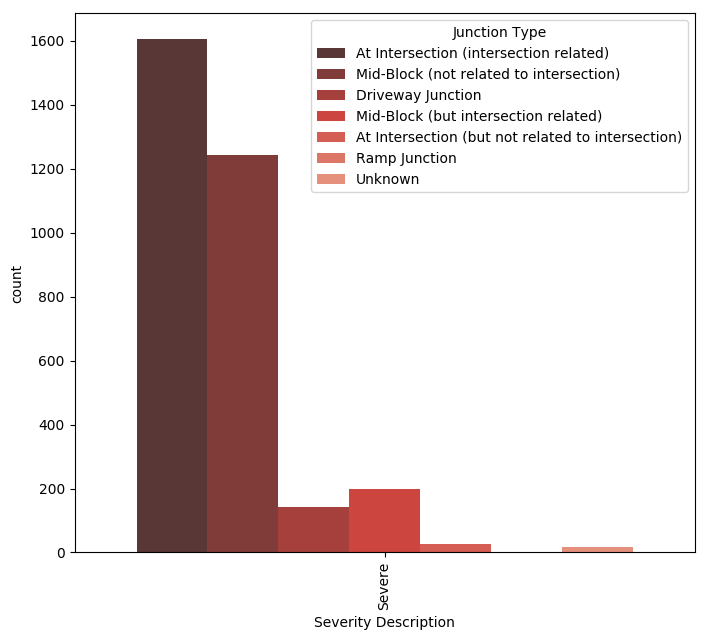

In [301]:
#Visualizing just the severity class
plt.figure(figsize=(8,7))
sns.countplot(hue='Junction Type',x='Severity Description',data=df_binary[df_binary['Severity Description']=='Severe'],palette='Reds_d')
plt.xticks(rotation=90)
plt.show()

### DUI

In [302]:
df_binary['DUI'].value_counts()

0.0        172626
Unknown     23705
1.0          9063
Name: DUI, dtype: int64

In [303]:
df_junctype = df_binary[['DUI','Severity Description','Latitude']].groupby(['DUI','Severity Description']).count().unstack()
df_junctype

Latitude                 
Severity Description Not Severe  Severe  Unknown
DUI                                             
0.0                    169941.0  2684.0      1.0
1.0                      8584.0   479.0      NaN
Unknown                  4872.0    72.0  18761.0

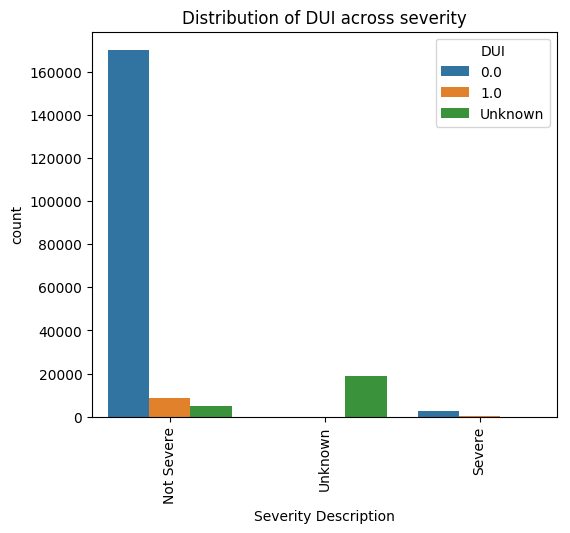

In [304]:
plt.figure(figsize=(6,5))
sns.countplot(hue='DUI',x='Severity Description',data=df_binary)
plt.title('Distribution of DUI across severity')
plt.xticks(rotation=90)
plt.show()

### Speed vs Severity Description

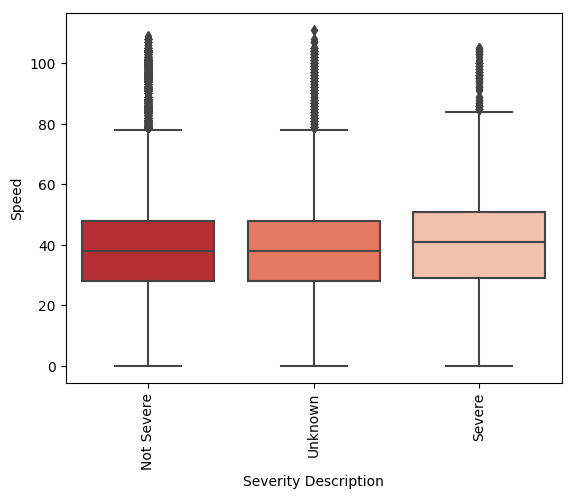

In [305]:
sns.boxplot(x='Severity Description',y='Speed',data=df_binary,palette='Reds_r')
plt.xticks(rotation=90)
plt.show()

In [306]:
df_binary[['Severity Description','Speed']].groupby('Severity Description').agg(['count','mean','median']).sort_values(('Speed','mean'),ascending=False)

Speed                  
                       count       mean median
Severity Description                          
Severe                  3230  41.413932   41.0
Unknown                18706  39.655939   38.0
Not Severe            182972  39.174256   38.0

Above, we visualize the speed variable across the severity categories and it's clear that the average speed for the severe case is higher than that of the non-severe and the unknown cases. 

# 5. Handling 'Unknown' category  

We have finally reached the point where we get rid of the *Unknown* category which would give us a completely cleaned dataset. This category is handled by combining it with the non-severe category for two main reasons: 
- The distributions for the unknown category, as seen from the multivariate analysis with the severity variable above, are more similar to the non-severe distributions than the severe ones. Hence it seems more rational to combine these two categories. 
- For crucial variables such as *Speed*, the distribution for the unknown category is similar to the non-severe one, both of which have a median of roughly 40 miles per hour. The median for severe is distinctly higher. 
- Also, there is more chances of mis-classification if the unknown category is combined with severe as that would push that category from ~1.5% to ~10% which is a big jump and would potentially provide false results. On the other hand, combining with the non-severe category would increase the size from ~89% to ~98% which would not have such a major impact on results as the non-severe category is already much larger. 

In [307]:
df_binary['Severity Description'] = df_binary['Severity Description'].replace('Unknown','Not Severe')

             Count  Severity Rate
Not Severe  202159      98.424978
Severe        3235       1.575022


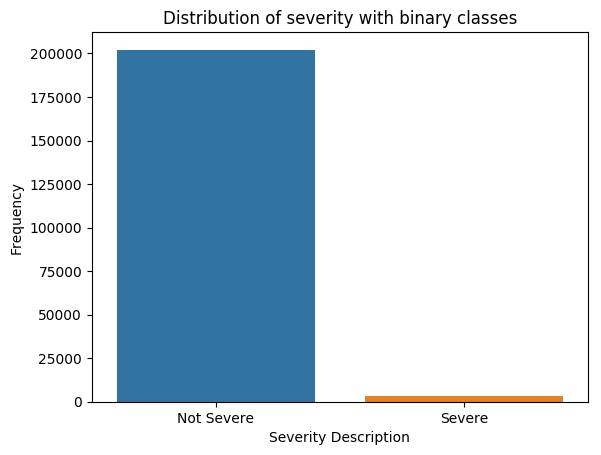

In [308]:
severity = pd.DataFrame()
severity['Count'] = df_binary['Severity Description'].value_counts()
severity['Severity Rate'] = severity['Count'].apply(lambda x: x/sum(severity['Count'])*100)
print (severity)

sns.countplot(x='Severity Description',data=df_binary)
plt.title('Distribution of severity with binary classes')
plt.ylabel('Frequency')
plt.show()

We have now removed the unkown category from the severity variable and have a clean dataset for further EDA. 

In [310]:
#df_binary.to_csv('completely_cleaned_dataset.csv')

### Variables not important for prediction
- Hit Parked Car
- Matched
- Collision Type
- DUI
- Number of People Involved
- Number of Vehicles Involved

### Important variables
- Neighborhood
- Speed
- Weather
- Road Conditions
- Light Conditions
- Address Type
- Junction Type
- Year
- Month
- Date
- Hour
- Traffic Congestion
- Road Length

Following EDA, we will perform further feature selection and engineering to come up with our baseline models. 